- Use etest to remove the perts that did not do stuff
- Show all 3: heatmap, dendro and a pathway scheme (if good)

In [12]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
%load_ext autoreload
%autoreload 2
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../figures/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATADIR = Path('/data/gpfs-1/users/peidlis_c/work/data/perturbation_resource_paper')
TEMPDIR = Path("/fast/scratch/users/peidlis_c/perturbation_resource_paper/")

In [3]:
adata = sc.read(TEMPDIR / 'tmp_data_PapalexiSatija2021_eccite_RNA.h5')

In [4]:
from scipy.cluster import hierarchy

In [7]:
ed = pd.read_csv('../snakemake/tables/pairwise_edist_PapalexiSatija2021_eccite_RNA_tables.csv', index_col=0)
ed = cluster_matrix(ed, 'both', method='single')
et = pd.read_csv('../snakemake/tables/etest_PapalexiSatija2021_eccite_RNA_tables.csv', index_col=0)

# Main

In [9]:
idx = et.index[(et.significant_adj) | (et.index=='control')]
ed_ = ed.loc[idx, idx]
ed_ = cluster_matrix(ed_, 'both', method='single')

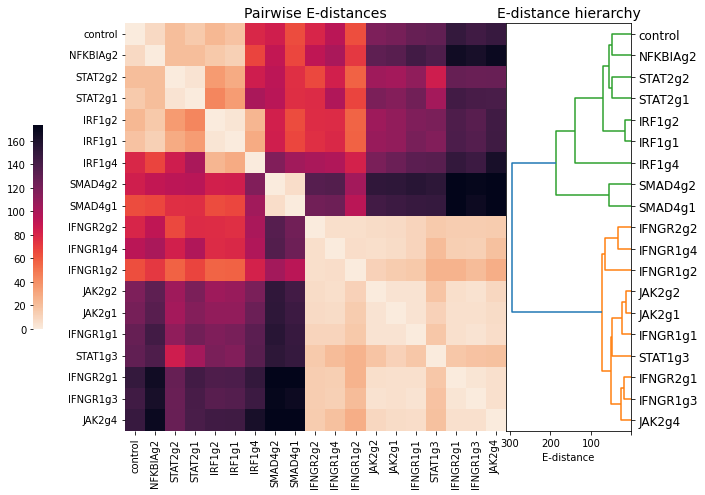

In [13]:
scale = 0.75
fig, axs = pl.subplots(1, 2, figsize=[(13+3)*scale,10*scale], gridspec_kw=dict(wspace=0, width_ratios=(13,3)))
title_kwargs = dict(fontsize=14)

ax = axs[1]
Z = hierarchy.linkage(ed_, 'single')
dn = hierarchy.dendrogram(Z, orientation='left', labels=ed_.index, ax=ax)
labels = [l.get_text() for l in ax.get_yticklabels()][::-1]
ax.set_title('E-distance hierarchy', **title_kwargs)
ax.set_xlabel('E-distance')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xticklabels(['', 100, 200, 300])

ax = axs[0]
sns.heatmap(ed_.loc[labels, labels], robust=True, cmap='rocket_r', ax=ax, cbar_kws={"shrink": 0.5, 'location': 'left', 'pad': 0.15})
ax.set_title('Pairwise E-distances', **title_kwargs)
pl.savefig(figure_path / 'FigX_Bio_interpretation_heatmap_dendrogram.pdf', bbox_inches='tight')
pl.show()

# Supplement

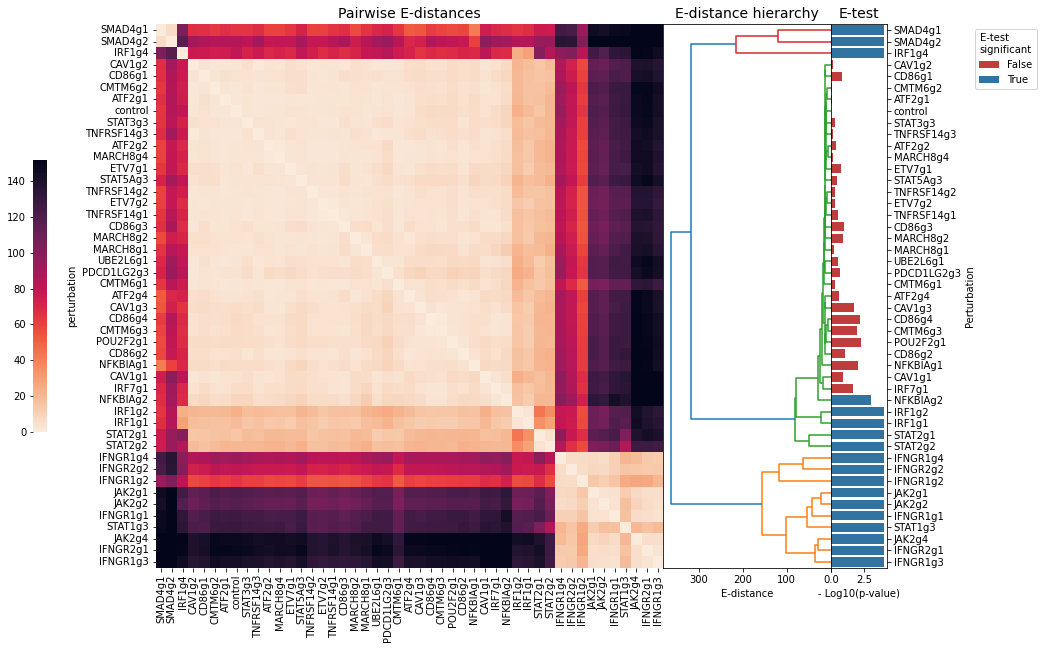

In [15]:
fig, axs = pl.subplots(1, 3, figsize=[13+3+1,10], gridspec_kw=dict(wspace=0, width_ratios=(13,3,1)))
title_kwargs = dict(fontsize=14)

ax = axs[1]
Z = hierarchy.linkage(ed, 'single')
dn = hierarchy.dendrogram(Z, orientation='left', labels=ed.index, ax=ax)
labels = [l.get_text() for l in ax.get_yticklabels()][::-1]
ax.set_title('E-distance hierarchy', **title_kwargs)
ax.set_xlabel('E-distance')
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xticklabels(['', 100, 200, 300])

ax = axs[0]
sns.heatmap(ed.loc[labels, labels], robust=True, cmap='rocket_r', ax=ax, cbar_kws={"shrink": 0.5, 'location': 'left', 'pad': 0.15})
ax.set_title('Pairwise E-distances', **title_kwargs)

ax = axs[2]
et['score_adj'] = -np.log10(et.pvalue_adj)
et['score'] = -np.log10(et.pvalue)
sns.barplot(data=et.loc[labels].reset_index(), y='index', x='score', ax=ax, 
            hue='significant_adj', dodge=False, palette={True: 'tab:blue', False: 'tab:red'})
sns.move_legend(ax, "upper left", bbox_to_anchor=(2.5, 1))
ax.legend_.set_title('E-test\nsignificant')
ax.set_ylabel('Perturbation')
ax.set_xlabel('- Log10(p-value)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_title('E-test', **title_kwargs)
pl.savefig(figure_path / 'SuppFig_Bio_interpretation_raw.pdf', bbox_inches='tight')
pl.show()